Import


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from PIL import Image

In [2]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
DATASET_PATH = "../Dataset"


Xử lý dữ liệu

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = ImageFolder(root=os.path.join(DATASET_PATH, "Train"), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)

mean = torch.zeros(3)
std = torch.zeros(3)
num_batches = 0

for batch, _ in train_loader:
    mean += batch.mean(dim=(0, 2, 3))
    std += batch.std(dim=(0, 2, 3))
    num_batches += 1

mean /= num_batches
std /= num_batches

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculated mean: tensor([0.4668, 0.3816, 0.3414])
Calculated std: tensor([0.2824, 0.2580, 0.2553])


In [45]:
train_transforms = transforms.Compose([
                            transforms.Resize((28, 28)),
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean.tolist(), std=std.tolist())
                                      ])

test_transforms = transforms.Compose([
                            transforms.Resize((28, 28)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean.tolist(), std=std.tolist())
                                     ])

In [46]:
train_data = ImageFolder(
    root=os.path.join(DATASET_PATH,"Train"),
    transform = train_transforms)

val_data = ImageFolder(
    root=os.path.join(DATASET_PATH,"Validation"),
    transform = test_transforms)

test_data = ImageFolder(
    root=os.path.join(DATASET_PATH,"Test"),
    transform = test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 140002
Number of validation examples: 39428
Number of testing examples: 10905


In [54]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data,
                            shuffle=True,
                            batch_size=BATCH_SIZE,
                            num_workers=4)

val_iterator = DataLoader(val_data,
                          batch_size=BATCH_SIZE,
                          num_workers=4)

test_iterator = DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=4)

In [55]:
print(len(train_iterator.dataset)) 
for batch in train_iterator:
    print(batch[0].shape)  
    break  


140002
torch.Size([64, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..2.3190093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..1.7813077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..1.9502997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..1.8037939].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..1.4572613].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528835..1.5822225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.652883

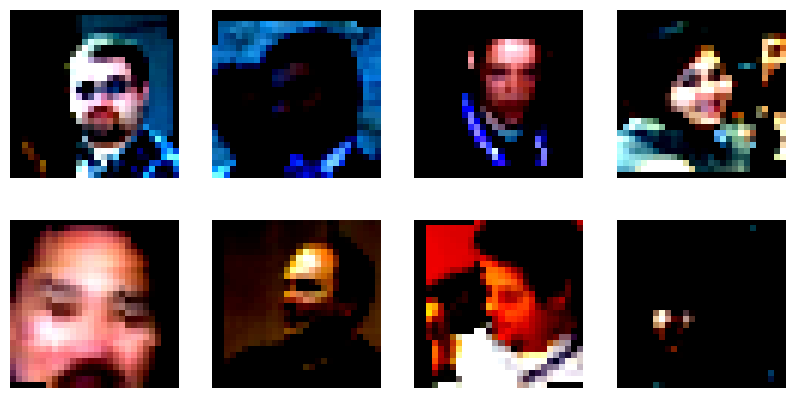

In [56]:
images, labels = next(iter(train_iterator))
images = images.numpy().transpose((0,2,3,1))

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for img, ax in zip(images[:8], axes):
    ax.imshow(img)
    ax.axis("off")

plt.show()

Định nghĩa mô hình

In [58]:
class LeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        # x = [B, 3, 28, 28]
        x = self.conv1(x)              # [B, 6, 28, 28]
        x = self.pool(x)               # [B, 6, 14, 14]
        x = F.relu(x)
        
        x = self.conv2(x)              # [B, 16, 10, 10]
        x = self.pool(x)               # [B, 16, 5, 5]
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)      # Flatten: [B, 16*5*5 = 400]
        x = F.relu(self.fc1(x))        # [B, 120]
        x = F.relu(self.fc2(x))        # [B, 84]
        x = self.fc3(x)                # [B, num_classes]
        return x

Chuẩn bị thiết bị, mô hình, loss, optimizer

In [59]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Huấn luyện 

In [60]:


save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, "best_lenet_model.pth")


num_epochs = 10
best_val_acc = 0.0  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_iterator_tqdm = tqdm(train_iterator, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_iterator_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = 100.0 * correct_train / total_train
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    
    val_loss /= total_val
    val_acc = 100.0 * correct_val / total_val
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Lưu mô hình nếu có val acc tốt hơn
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"--> Saved best model with Val Acc: {best_val_acc:.2f}%")

print("Training complete! Best Val Acc: {:.2f}%".format(best_val_acc))

Epoch 1/10: 100%|██████████| 2188/2188 [03:42<00:00,  9.84it/s]


Epoch [1/10] | Train Loss: 0.5142, Train Acc: 73.77% | Val Loss: 0.4783, Val Acc: 76.55%
--> Saved best model with Val Acc: 76.55%


Epoch 2/10: 100%|██████████| 2188/2188 [01:30<00:00, 24.10it/s]


Epoch [2/10] | Train Loss: 0.4375, Train Acc: 78.94% | Val Loss: 0.4718, Val Acc: 76.67%
--> Saved best model with Val Acc: 76.67%


Epoch 3/10: 100%|██████████| 2188/2188 [01:37<00:00, 22.35it/s]


Epoch [3/10] | Train Loss: 0.4124, Train Acc: 80.38% | Val Loss: 0.4311, Val Acc: 79.14%
--> Saved best model with Val Acc: 79.14%


Epoch 4/10: 100%|██████████| 2188/2188 [01:27<00:00, 24.88it/s]


Epoch [4/10] | Train Loss: 0.3980, Train Acc: 81.18% | Val Loss: 0.4601, Val Acc: 77.38%


Epoch 5/10: 100%|██████████| 2188/2188 [01:34<00:00, 23.12it/s]


Epoch [5/10] | Train Loss: 0.3851, Train Acc: 81.97% | Val Loss: 0.4227, Val Acc: 79.77%
--> Saved best model with Val Acc: 79.77%


Epoch 6/10: 100%|██████████| 2188/2188 [01:34<00:00, 23.17it/s]


Epoch [6/10] | Train Loss: 0.3740, Train Acc: 82.54% | Val Loss: 0.4114, Val Acc: 80.65%
--> Saved best model with Val Acc: 80.65%


Epoch 7/10: 100%|██████████| 2188/2188 [01:32<00:00, 23.78it/s]


Epoch [7/10] | Train Loss: 0.3654, Train Acc: 83.17% | Val Loss: 0.3988, Val Acc: 81.35%
--> Saved best model with Val Acc: 81.35%


Epoch 8/10: 100%|██████████| 2188/2188 [01:38<00:00, 22.27it/s]


Epoch [8/10] | Train Loss: 0.3579, Train Acc: 83.53% | Val Loss: 0.3967, Val Acc: 81.21%


Epoch 9/10: 100%|██████████| 2188/2188 [01:38<00:00, 22.26it/s]


Epoch [9/10] | Train Loss: 0.3527, Train Acc: 83.80% | Val Loss: 0.3881, Val Acc: 81.71%
--> Saved best model with Val Acc: 81.71%


Epoch 10/10: 100%|██████████| 2188/2188 [01:31<00:00, 23.96it/s]


Epoch [10/10] | Train Loss: 0.3455, Train Acc: 84.22% | Val Loss: 0.3889, Val Acc: 81.60%
Training complete! Best Val Acc: 81.71%


Đánh giá trên tập test


In [61]:

model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in tqdm(test_iterator, desc="Đánh giá trên tập test"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_loss /= total_test
test_acc = 100.0 * correct_test / total_test
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Đánh giá trên tập test: 100%|██████████| 171/171 [00:41<00:00,  4.09it/s]

Test Loss: 0.4276, Test Accuracy: 79.47%


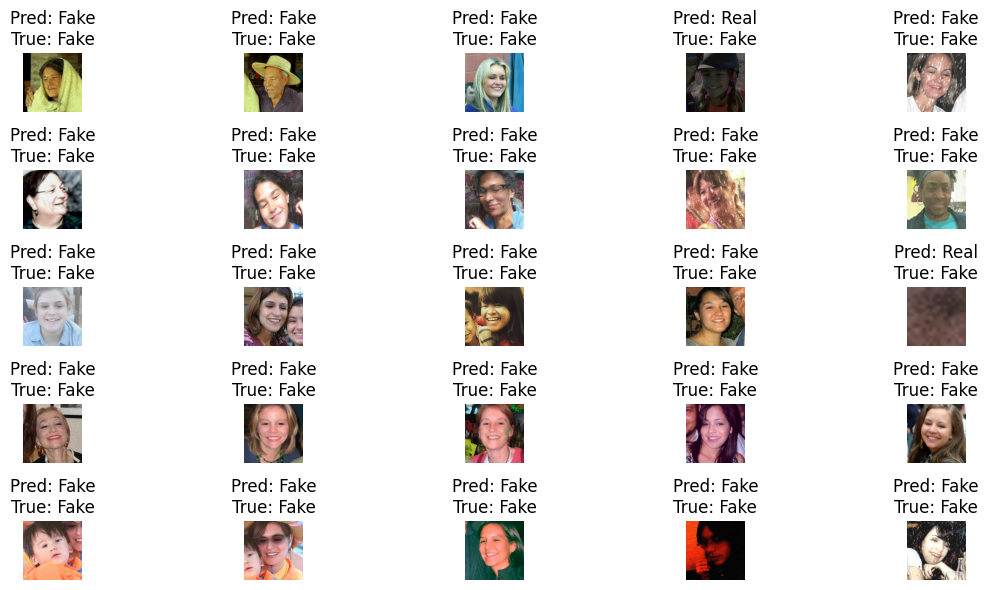

In [ ]:
images, labels = next(iter(test_iterator))
images = images.to(device)

outputs = model(images)
_, predicted = outputs.max(1)

# Tạo mapping từ index sang class name (ví dụ: {'Fake': 0, 'Real': 1} trở thành {0: 'Fake', 1: 'Real'})
idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}

samples = test_data.samples[:25]

fig, axes = plt.subplots(5, 5, figsize=(12, 6))
axes = axes.flatten()

for idx, (img_path, label) in enumerate(samples):
    true_label = idx_to_class[labels[idx].item()]
    pred_label = idx_to_class[predicted[idx].item()]
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(f"Pred: {pred_label}\nTrue: {true_label}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

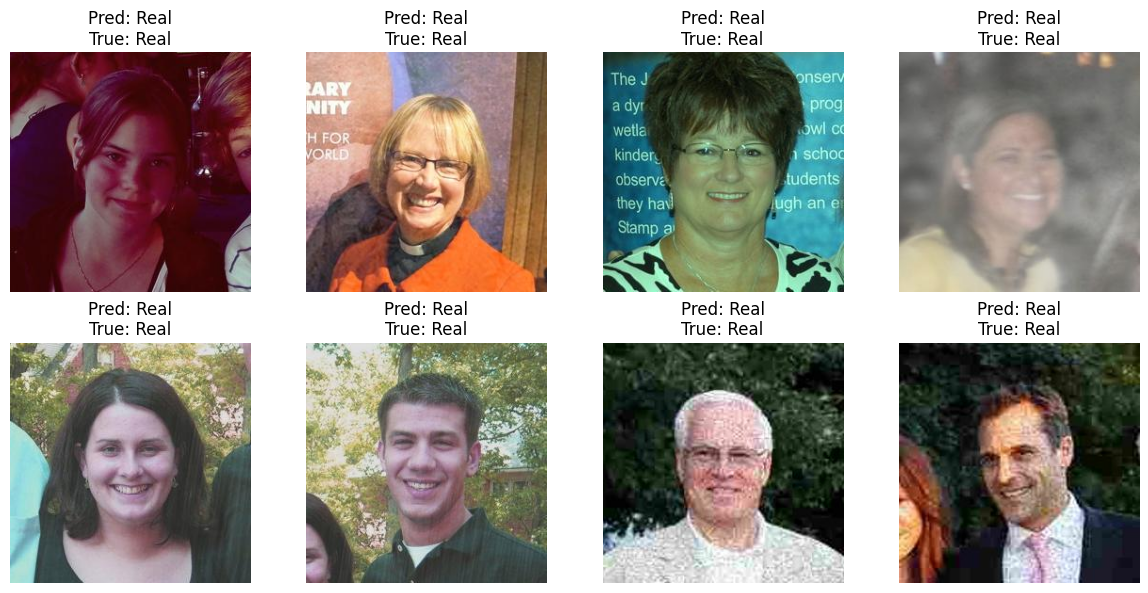

In [ ]:
predicted_real_true_real_samples = []

model.eval()
with torch.no_grad():
    index = 0  
    for images, labels in test_iterator:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        batch_size = images.size(0)
        
        for i in range(batch_size):
            pred_label = idx_to_class[predicted[i].item()]
            true_label = idx_to_class[labels[i].item()]
            if pred_label == "Real" and true_label == "Real":
                file_path, _ = test_data.samples[index + i]
                predicted_real_true_real_samples.append((file_path, true_label))
        index += batch_size

num_show = 8
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_show):
    if i < len(predicted_real_true_real_samples):
        file_path, true_label = predicted_real_true_real_samples[i]
        img = Image.open(file_path)  
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: Real\nTrue: {true_label}")
        axes[i].axis("off")
    else:
        axes[i].axis("off")

plt.tight_layout()
plt.show()